# Using MCMC for regression of !Kungs' height on their weight

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Alpha": r"$\alpha$", "Beta": r"$\beta$"})

In [3]:
ALPHA = 0.11

Data

In [4]:
Dat = pd.read_csv('Data/Howell1.csv', sep=';').sort_values('weight').reset_index(drop=True)
WeightStandard = (Dat['weight']-Dat['weight'].mean())/Dat['weight'].std()

---

Fit the model and sample from the prior predictive.

In [5]:
with pm.Model() as ModelHeightWeight:
    Alpha    = pm.Normal('Alpha', mu=170, sigma=3)
    Beta     = pm.Gamma('Beta', alpha=5, beta=5)
    Sigma    = pm.Uniform('Sigma', lower=0, upper=20)
    Mu       = pm.Deterministic('Mu', Alpha + Beta * WeightStandard)
    Height   = pm.Normal('Height', mu=Mu, sigma=Sigma, observed=Dat['height'])

    TraceModelHeightWeight = pm.sample_prior_predictive()   

Sampling: [Alpha, Beta, Height, Sigma]


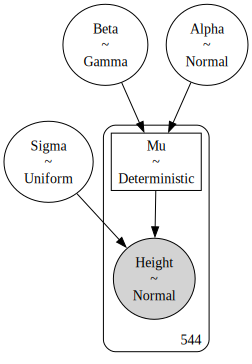

In [6]:
pm.model_to_graphviz(ModelHeightWeight)

Text(0, 0.5, 'Average height')

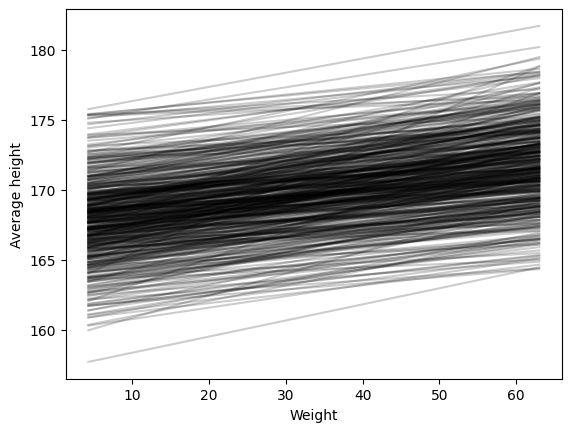

In [7]:
x_min, x_max = Dat['weight'].min(), Dat['weight'].max()
x = np.linspace((x_min-Dat['weight'].mean())/Dat['weight'].std(), (x_max-Dat['weight'].mean())/Dat['weight'].std())

PriorAlpha = TraceModelHeightWeight.prior.Alpha.values[0]
PriorBeta = TraceModelHeightWeight.prior.Beta.values[0]

for a, b in zip(PriorAlpha, PriorBeta):
    y = a + b*x
    plt.plot(x * Dat['weight'].std() + Dat['weight'].mean(), y, c='k', alpha=0.2)

plt.xlabel('Weight')
plt.ylabel('Average height')

Sample from the posterior

In [8]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: >, None],
       [<Axes: xlabel='$\\alpha$', ylabel='$\\beta$'>, <Axes: >]],
      dtype=object)

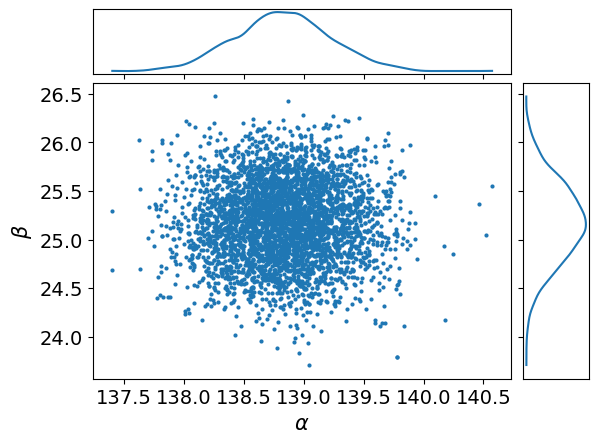

In [9]:
az.plot_pair(TraceModelHeightWeight, var_names=['Alpha', 'Beta'], marginals=True, labeller=labeller)

Sample from the predictive posterior

In [10]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample_posterior_predictive(TraceModelHeightWeight))

Sampling: [Height]


Plot the posterior predictive

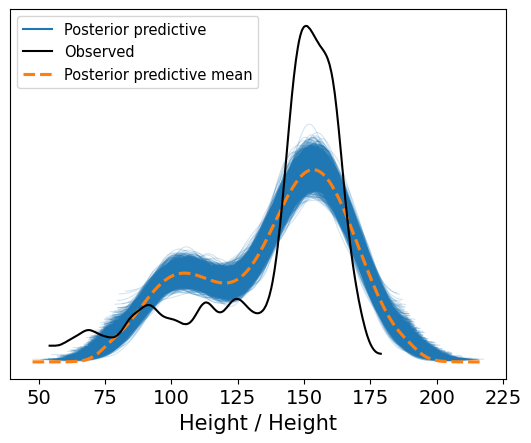

In [11]:
az.plot_ppc(TraceModelHeightWeight)

Plot the regression function with confidence and prediction intervals

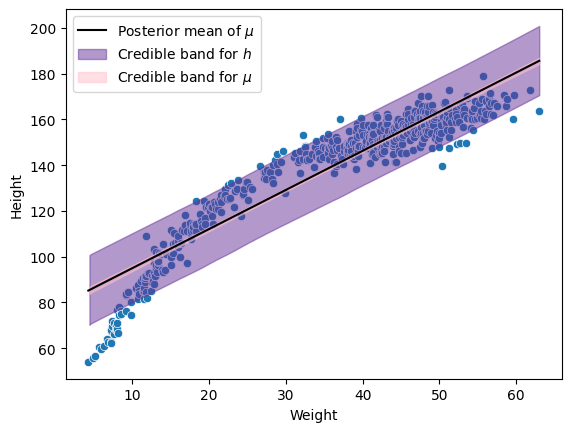

In [12]:
sns.scatterplot(x=Dat['weight'], y=Dat['height'])

plt.plot(
    Dat['weight']
    , TraceModelHeightWeight.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean of $\mu$"
    , color='k'
)

az.plot_hdi(
    Dat['weight']
    , TraceModelHeightWeight.posterior_predictive.Height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $h$"}
)

az.plot_hdi(
    Dat['weight']
    , TraceModelHeightWeight.posterior.Mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $\mu$"}
)

plt.legend()

plt.xlabel('Weight')
plt.ylabel('Height')

---

We fit now a quadratic model

In [13]:
with pm.Model() as ModelHeightWeight2:
    Alpha    = pm.Normal('Alpha', mu=170, sigma=3)
    Beta1    = pm.Gamma('Beta1', alpha=5, beta=5)
    Beta2    = pm.Normal('Beta2', mu=0, sigma=1)
    Sigma    = pm.Uniform('Sigma', lower=0, upper=20)
    Mu       = pm.Deterministic('Mu', Alpha + Beta1 * WeightStandard + Beta2 * WeightStandard**2)
    Height   = pm.Normal('Height', mu=Mu, sigma=Sigma, observed=Dat['height'])

    TraceModelHeightWeight2 = pm.sample_prior_predictive()   

Sampling: [Alpha, Beta1, Beta2, Height, Sigma]


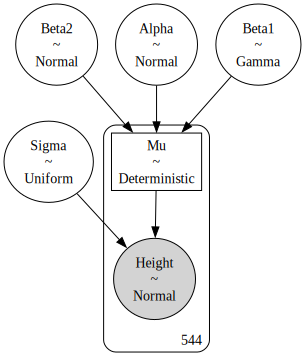

In [14]:
pm.model_to_graphviz(ModelHeightWeight2)

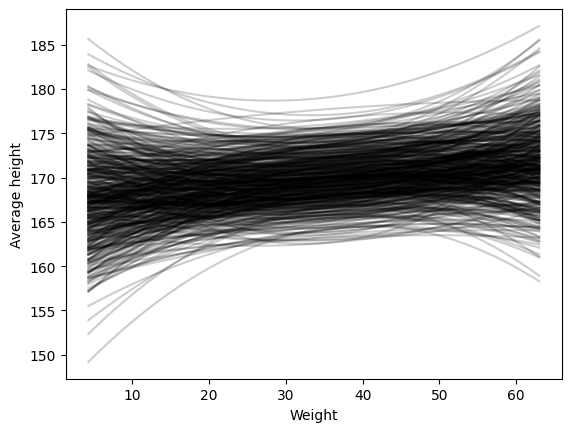

In [15]:
x_min, x_max = Dat['weight'].min(), Dat['weight'].max()
x = np.linspace((x_min-Dat['weight'].mean())/Dat['weight'].std(), (x_max-Dat['weight'].mean())/Dat['weight'].std())

PriorAlpha = TraceModelHeightWeight2.prior.Alpha.values[0]
PriorBeta1 = TraceModelHeightWeight2.prior.Beta1.values[0]
PriorBeta2 = TraceModelHeightWeight2.prior.Beta2.values[0]

for a, b, c in zip(PriorAlpha, PriorBeta1, PriorBeta2):
    y = a + b*x + c*x**2
    plt.plot(x * Dat['weight'].std() + Dat['weight'].mean(), y, c='k', alpha=0.2)

plt.xlabel('Weight')
plt.ylabel('Average height')

In [16]:
with ModelHeightWeight2:
    TraceModelHeightWeight2.extend(pm.sample())
    TraceModelHeightWeight2.extend(pm.sample_posterior_predictive(TraceModelHeightWeight2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta1, Beta2, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [Height]


Plot the posterior predictive

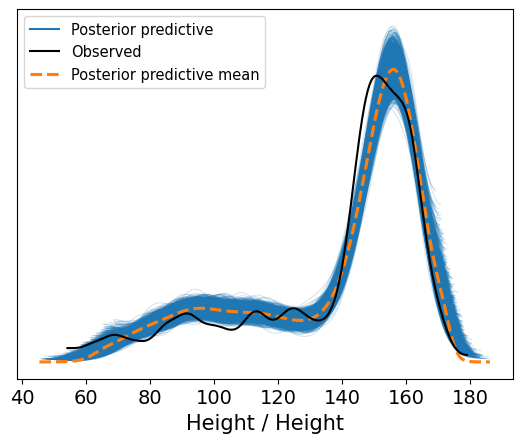

In [17]:
az.plot_ppc(TraceModelHeightWeight2)

Plot the regression function with confidence and prediction intervals

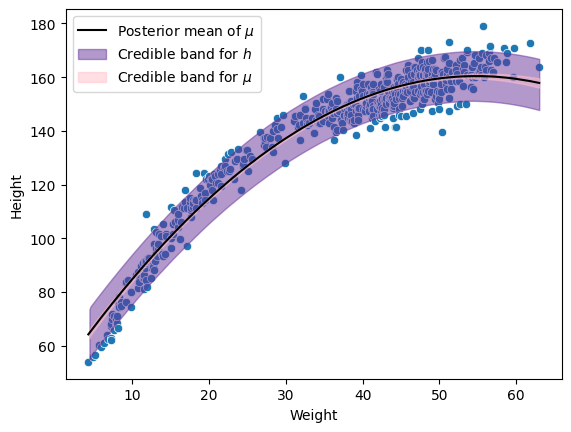

In [18]:
sns.scatterplot(x=Dat['weight'], y=Dat['height'])

plt.plot(
    Dat['weight']
    , TraceModelHeightWeight2.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean of $\mu$"
    , color='k'
)

az.plot_hdi(
    Dat['weight']
    , TraceModelHeightWeight2.posterior_predictive.Height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $h$"}
)

az.plot_hdi(
    Dat['weight']
    , TraceModelHeightWeight2.posterior.Mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':r"Credible band for $\mu$"}
)

plt.legend()

plt.xlabel('Weight')
plt.ylabel('Height')